In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from celluloid import Camera
import math as mt
from functools import reduce
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor, PrevPublicPredictor
from IPython.display import clear_output, Markdown, display

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

In [4]:
# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)
m.head()

,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401,아파트1-101-1403,아파트1-101-1502,아파트1-101-1504,아파트1-101-1602,...,아파트1-104-303,아파트1-104-404,아파트1-104-408,아파트1-104-503,아파트1-104-507,아파트1-104-606,아파트1-104-705,아파트1-104-708,아파트1-104-902,아파트1-104-905
month,,,,,,,,,,,,,,,,,,,,,
1,253,689,183,239,455,343,380,219,389,350,...,10,111,39,151,181,180,290,184,176,148
2,251,481,177,218,397,297,339,197,348,288,...,77,107,30,114,151,151,263,177,158,127
3,255,424,203,222,378,303,349,202,357,368,...,77,120,28,116,163,157,281,182,171,127
4,252,355,180,230,368,278,298,188,346,365,...,76,64,58,109,151,148,257,175,140,121
5,230,357,258,203,414,270,418,156,320,265,...,150,63,75,137,115,13,84,149,36,117


In [69]:
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)
month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
households_kWh = month_df['usage (kWh)'].sum()
APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))

# 공용부 사용량이 APT 상에서 30%를 차지하도록 설정
public_kWh = APT - households_kWh

# 예측 시뮬레이션
pp = PublicPredictor(
    APT=APT,
    month_df=month_df,
    month=_month
)

calc = crs.models.ManagementOffice(
    APT = APT,
    month = _month,
    households = month_df,
    contract="단일계약"
)

# 데이터

In [70]:
month_df.head(10)

,name,usage (kWh)
0,아파트1-101-1002,253
1,아파트1-101-104,689
2,아파트1-101-1102,183
3,아파트1-101-1202,239
4,아파트1-101-1302,455
5,아파트1-101-1401,343
6,아파트1-101-1403,380
7,아파트1-101-1502,219
8,아파트1-101-1504,389
9,아파트1-101-1602,350


# 테스트 환경

In [71]:
pp.predict

실제 요금    2640560
예측 요금    2639700
오차           860
dtype: int64

In [72]:
target_df = month_df.copy()

target_df = target_df[target_df['name'] == "아파트1-104-708"]
target_usage = target_df['usage (kWh)'].values[0]
target_df.head()

,name,usage (kWh)
105,아파트1-104-708,184


# 기본요금

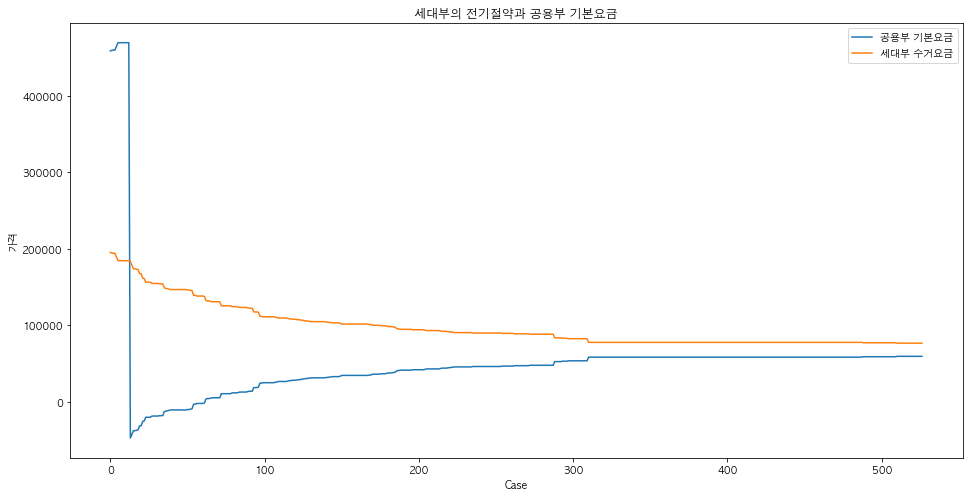

,APT,세대부 총 사용량,공용부 총 사용량,아파트 전체 기본요금,공용부 기본요금,세대부 수거요금
0,44345,31015,13330,654480,459190,195290
1,44256,30926,13330,654480,459720,194760
2,44167,30837,13330,654480,460250,194230
3,44078,30748,13330,654480,460250,194230
4,43989,30659,13330,654480,465050,189430


In [84]:
basic_df = pd.DataFrame(columns=['APT', '세대부 총 사용량', '공용부 총 사용량',
                                 '아파트 전체 기본요금', '공용부 기본요금', '세대부 수거요금'])
basic_month_df = month_df.copy()

while True:
    target_cnt = len(basic_month_df[basic_month_df['usage (kWh)'] > target_usage])
    
    if target_cnt == 0:
        break
    
    basic_month_df['usage (kWh)'] = basic_month_df['usage (kWh)'].map(lambda x: x-1 if x > target_usage else x)
    
    households_kWh = basic_month_df['usage (kWh)'].sum()
    APT = public_kWh + households_kWh
    
    # 예측 시뮬레이션
    pp = PublicPredictor(
        APT=APT,
        month_df=basic_month_df,
        month=_month
    )
    pp.setting_basic()

    calc = crs.models.ManagementOffice(
        APT = APT,
        month = _month,
        households = basic_month_df,
        contract="단일계약"
    )
    
    APT_basic = calc.apart.basic * len(basic_month_df)
    public_basic = pp.basic
    households_basic = APT_basic - public_basic
    
    basic_df = basic_df.append({
        "APT": APT,
        "세대부 총 사용량": households_kWh,
        "공용부 총 사용량": public_kWh,
        "아파트 전체 기본요금": APT_basic,
        "공용부 기본요금": public_basic,
        "세대부 수거요금": households_basic
    }, ignore_index=True)
    
plt.figure(figsize=(16,8))

plt.plot(basic_df['공용부 기본요금'], label='공용부 기본요금')
plt.plot(basic_df['세대부 수거요금'], label='세대부 수거요금')

plt.legend(loc='upper right')
plt.title("세대부의 전기절약과 공용부 기본요금")
plt.xlabel("Case")
plt.ylabel("가격")

plt.show()
# table index 10 30 100 300
basic_df.head()

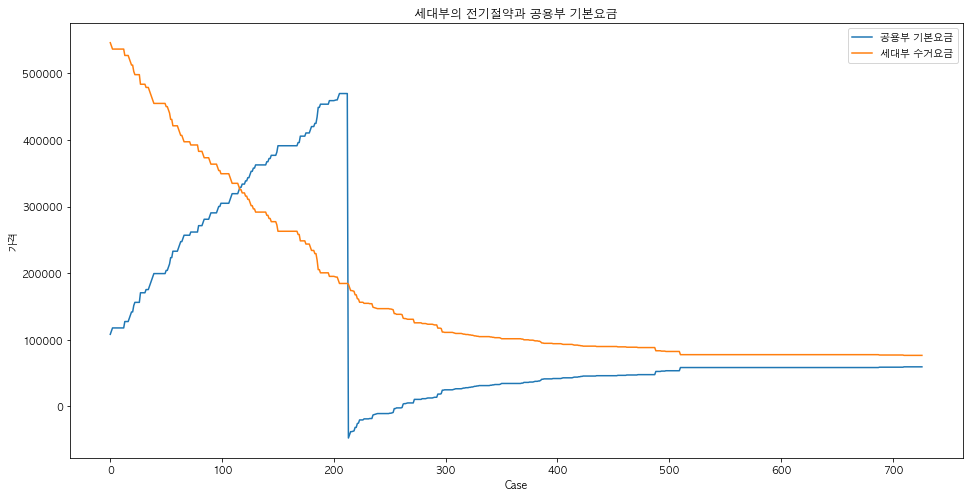

,APT,세대부 총 사용량,공용부 총 사용량,아파트 전체 기본요금,공용부 기본요금,세대부 수거요금
0,62145,48815,13330,654480,108260,546220
1,62056,48726,13330,654480,113060,541420
2,61967,48637,13330,654480,117860,536620
3,61878,48548,13330,654480,117860,536620
4,61789,48459,13330,654480,117860,536620


In [82]:
basic_df = pd.DataFrame(columns=['APT', '세대부 총 사용량', '공용부 총 사용량',
                                 '아파트 전체 기본요금', '공용부 기본요금', '세대부 수거요금'])
basic_month_df = month_df.copy()
basic_month_df['usage (kWh)'] = basic_month_df['usage (kWh)'].map(lambda x: x+200 if x > target_usage else x)
while True:
    target_cnt = len(basic_month_df[basic_month_df['usage (kWh)'] > target_usage])
    
    if target_cnt == 0:
        break
    
    basic_month_df['usage (kWh)'] = basic_month_df['usage (kWh)'].map(lambda x: x-1 if x > target_usage else x)
    
    households_kWh = basic_month_df['usage (kWh)'].sum()
    APT = public_kWh + households_kWh
    
    # 예측 시뮬레이션
    pp = PublicPredictor(
        APT=APT,
        month_df=basic_month_df,
        month=_month
    )
    pp.setting_basic()

    calc = crs.models.ManagementOffice(
        APT = APT,
        month = _month,
        households = basic_month_df,
        contract="단일계약"
    )
    
    APT_basic = calc.apart.basic * len(basic_month_df)
    public_basic = pp.basic
    households_basic = APT_basic - public_basic
    
    basic_df = basic_df.append({
        "APT": APT,
        "세대부 총 사용량": households_kWh,
        "공용부 총 사용량": public_kWh,
        "아파트 전체 기본요금": APT_basic,
        "공용부 기본요금": public_basic,
        "세대부 수거요금": households_basic
    }, ignore_index=True)
    
plt.figure(figsize=(16,8))

plt.plot(basic_df['공용부 기본요금'], label='공용부 기본요금')
plt.plot(basic_df['세대부 수거요금'], label='세대부 수거요금')

plt.legend(loc='upper right')
plt.title("세대부의 전기절약과 공용부 기본요금")
plt.xlabel("Case")
plt.ylabel("가격")

plt.show()
basic_df.head()

# 전력량요금

In [162]:
er_df = pd.DataFrame(columns=['APT', '세대부 총 사용량', '공용부 총 사용량',
                                 '아파트 전체 전력량요금', '공용부 전력량요금', '세대부 수거요금'])
er_month_df = month_df.copy()

while True:
    target_cnt = len(er_month_df[er_month_df['usage (kWh)'] > target_usage])
    
    if target_cnt == 0:
        break
    
    er_month_df['usage (kWh)'] = er_month_df['usage (kWh)'].map(lambda x: x-1 if x > target_usage else x)
    
    households_kWh = er_month_df['usage (kWh)'].sum()
    APT = public_kWh + households_kWh
    
    # 예측 시뮬레이션
    pp = PublicPredictor(
        APT=APT,
        month_df=er_month_df,
        month=_month
    )
    pp.setting_elec_rate()

    calc = crs.models.ManagementOffice(
        APT = APT,
        month = _month,
        households = er_month_df,
        contract="단일계약"
    )
    
    APT_er = calc.apart.elec_rate * len(er_month_df)
    public_er = pp.elec_rate
    households_er = APT_er - public_er
    
    er_df = er_df.append({
        "APT": APT,
        "세대부 총 사용량": households_kWh,
        "공용부 총 사용량": public_kWh,
        "아파트 전체 전력량요금": APT_er,
        "공용부 전력량요금": public_er,
        "세대부 수거요금": households_er
    }, ignore_index=True)
    
er_df.head()

,APT,세대부 총 사용량,공용부 총 사용량,아파트 전체 전력량요금,공용부 전력량요금,세대부 수거요금
0,44345,31015,13330,4907088,1805794,3101294
1,44256,30926,13330,4884408,1796669,3087739
2,44167,30837,13330,4861620,1787476,3074144
3,44078,30748,13330,4838832,1778212,3060620
4,43989,30659,13330,4816152,1768950,3047202


In [163]:
start_er_df = pd.DataFrame(columns=['APT', '세대부 총 사용량', '공용부 총 사용량',
                                 '아파트 전체 전력량요금', '공용부 전력량요금 시작요금', '세대부 수거요금'])
start_er_month_df = month_df.copy()

while True:
    target_cnt = len(start_er_month_df[start_er_month_df['usage (kWh)'] > target_usage])
    
    if target_cnt == 0:
        break
    
    start_er_month_df['usage (kWh)'] = start_er_month_df['usage (kWh)'].map(lambda x: x-1 if x > target_usage else x)
    
    households_kWh = start_er_month_df['usage (kWh)'].sum()
    APT = public_kWh + households_kWh
    
    # 예측 시뮬레이션
    pp = PublicPredictor(
        APT=APT,
        month_df=start_er_month_df,
        month=_month
    )
    pp.setting_elec_rate()

    calc = crs.models.ManagementOffice(
        APT = APT,
        month = _month,
        households = start_er_month_df,
        contract="단일계약"
    )
    
    APT_er = calc.apart.elec_rate * len(start_er_month_df)
    public_er = pp.start_elec_rate
    households_er = APT_er - public_er
    
    start_er_df = start_er_df.append({
        "APT": APT,
        "세대부 총 사용량": households_kWh,
        "공용부 총 사용량": public_kWh,
        "아파트 전체 전력량요금": APT_er,
        "공용부 전력량요금 시작요금": public_er,
        "세대부 수거요금": households_er
    }, ignore_index=True)
    
start_er_df.head()

,APT,세대부 총 사용량,공용부 총 사용량,아파트 전체 전력량요금,공용부 전력량요금 시작요금,세대부 수거요금
0,44345,31015,13330,4907088,-181028,5088116
1,44256,30926,13330,4884408,-182777,5067185
2,44167,30837,13330,4861620,-169225,5030845
3,44078,30748,13330,4838832,-171112,5009944
4,43989,30659,13330,4816152,-172998,4989150


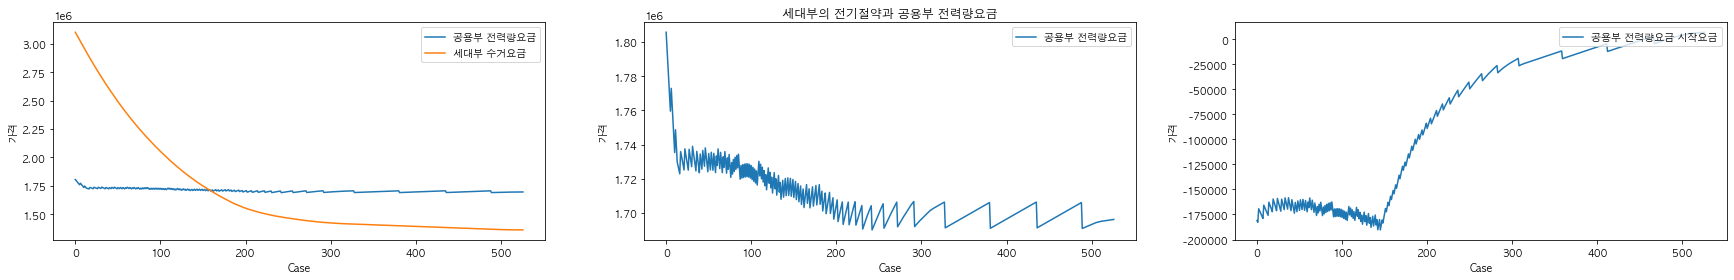

In [166]:
plt.figure(figsize=(30, 4))

ax_1 = plt.subplot(1,3, 1)
ax_1.plot(er_df['공용부 전력량요금'], label='공용부 전력량요금')
ax_1.plot(er_df['세대부 수거요금'], label='세대부 수거요금')

ax_1.legend(loc='upper right')
plt.xlabel("Case")
plt.ylabel("가격")

ax_2 = plt.subplot(1,3, 2)
ax_2.plot(er_df['공용부 전력량요금'], label='공용부 전력량요금')

ax_2.legend(loc='upper right')
ax_2.set_title("세대부의 전기절약과 공용부 전력량요금")
plt.xlabel("Case")
plt.ylabel("가격")

ax_3 = plt.subplot(1,3, 3)
ax_3.plot(start_er_df['공용부 전력량요금 시작요금'], label='공용부 전력량요금 시작요금')

ax_3.legend(loc='upper right')
plt.xlabel("Case")
plt.ylabel("가격")

plt.show()